# Theory Beakdown
This breaks down each contribution to the theoretical scaling factor.

In [30]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat, decompose_temp_ft_anom_change, get_p_x
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [31]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/ras_conv/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
if 'ras_conv' in exp_dir:
    var_keep = ['temp', 'sphum', 'height']
else:
    var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/2 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [32]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

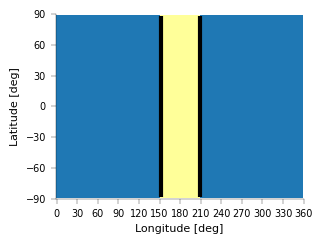

In [33]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [34]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
sphum_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median', 'mean_from_sphum', 'mean_from_r', 'median_from_sphum', 'median_from_r']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median', 'mean_from_sphum', 'mean_from_r', 'median_from_sphum', 'median_from_r']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
mse_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
mse_ft_sat_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
mse_mod_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        sphum_av['mean_from_sphum'][j] = ds_use.sphum[0].mean(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean_from_r'][j] = rh_use.mean(dim='lon_time')
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_av['mean'][j] = mse_use[0].mean(dim='lon_time')
        mse_ft_sat_av['mean'][j] = mse_use[1].mean(dim='lon_time')
        epsilon_use = mse_use[0] - mse_use[1]
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        mse_mod_use = moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + lnp_const)
        mse_mod_av['mean'][j] = mse_mod_use.mean(dim='lon_time')
        pbar.update(1)
sphum_av['mean_from_r'] = r_av['mean_from_r'] * sphum_sat(temp_av['mean'][:, ind_surf], p_surface) 
r_av['mean_from_sphum'] = sphum_av['mean_from_sphum'] / sphum_sat(temp_av['mean'][:, ind_surf], p_surface) 

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



In [11]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
sphum_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
sphum_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting
mse_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_ft_sat_quant3 = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_mod_quant3 = np.zeros((n_kappa, n_lat, n_quant))

temp_ft_quant = np.zeros((n_kappa, n_lat, n_quant))             # quantile as function of ft temp not surf temp

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_mod_use = moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + lnp_const)
        epsilon_use = mse_use[0] - mse_use[1]
        if 'klzbs' in var_keep:
            is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for q, quant in enumerate(quant_plot):
            temp_ft_quant[j, :, q] = ds_use.temp.isel(pfull=ind_ft).quantile(quant/100, dim='lon_time')
            for k in range(n_lat):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3_from_sphum[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                r_quant3_from_r[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                mse_quant3[j, k, q] = mse_use[0][k, use_ind].mean(dim='lon_time')
                mse_ft_sat_quant3[j, k, q] = mse_use[1][k, use_ind].mean(dim='lon_time')
                epsilon_quant3[j, k, q] = epsilon_use[k, use_ind].mean(dim='lon_time')
                mse_mod_quant3[j, k, q] = mse_mod_use[k, use_ind].mean(dim='lon_time')
                if 'klzbs' in var_keep:
                    convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3_from_r = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3_from_r # compute specific humidity from relative humidity
r_quant3_from_sphum = sphum_quant3_from_sphum / sphum_sat(temp_quant3[:, ind_surf], p_surface)
# temp_anom = temp_quant3 - temp_mean[:, :, :, np.newaxis]
# epsilon_anom = epsilon_quant3 - epsilon_mean[:, :, np.newaxis]

  0%|          | 0/2772 [00:00<?, ?it/s]

### Median Climate
Compute median climate from `_quant3` with $x=50$

In [12]:
quant_median = 50
quant_median_ind = int(np.where(quant_plot==quant_median)[0])
temp_av['median'] = temp_quant3[:, :, :, quant_median_ind]
sphum_av['median_from_sphum'] = sphum_quant3_from_sphum[:, :, quant_median_ind]
sphum_av['median_from_r'] = sphum_quant3_from_r[:, :, quant_median_ind]
r_av['median_from_sphum'] = r_quant3_from_sphum[:, :, quant_median_ind]
r_av['median_from_r'] = r_quant3_from_r[:, :, quant_median_ind]
z_av['median'] = z_quant3[:, :, :, quant_median_ind]
mse_av['median'] = mse_quant3[:, :, quant_median_ind]
mse_ft_sat_av['median'] = mse_quant3[:, :, quant_median_ind]
epsilon_av['median'] = epsilon_quant3[:, :, quant_median_ind]
mse_mod_av['median'] = mse_mod_quant3[:, :, quant_median_ind]

# As a function of ft quantile not surface quantile
temp_ft_median = temp_ft_quant[:, :, quant_median_ind]

## Humidity Calculation
Specific and relative humidity are related through $q_s = r_s q^*(T_s, p_s)$. When taking the mean, due to non-linear $q_s$ function, there is a difference between the value of $q_s$ when it is computed from the average of $r_s$ over all days ($r$ method) to when it is taken as the average of specific humidity on each day ($q$ method).

Below I investigate the effect of this. The difference is only apparent in the mean value, not as a function of quantile.

### Effect on MSE and $\epsilon$
At the surface, MSE is defined as $h_s = c_p T_s + L_v q_s + gz_s$. Thus it is senstive to the $q_s$ used:
* $q$ method: This is equivalent to taking $\overline{q_s}$ to be the average specific humidity for all days.
* $r$ method: Here, I compute $\overline{q_s} = \overline{r_s} q^*(\overline{T_s}, p_s)$. Where $\overline{r_s}$ is the relative humidity averaged over all days.

The $q$ method matches the simulated mean value exactly. However, we see that the $r$ method over-estimates $\overline{h}$, but it has the advantage that $\overline{r_s}$ must be less than 1 in this case (see above).

For our simulations, I think it makes sense to use the $q$ method as we always have $r<1$ anyway from tropical summer, but the $\epsilon$ effect is apparent.

In [13]:
mse_av['mean_from_sphum'] = moist_static_energy(temp_av['mean'][:, ind_surf], sphum_av['mean_from_sphum'], z_av['mean'][:, ind_surf])
mse_quant3_from_sphum = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])
mse_av['mean_from_r'] = moist_static_energy(temp_av['mean'][:, ind_surf], sphum_av['mean_from_r'], z_av['mean'][:, ind_surf])
mse_quant3_from_r = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])

epsilon_av['mean_from_sphum'] = mse_av['mean_from_sphum'] - mse_ft_sat_av['mean']
epsilon_quant3_from_sphum = mse_quant3_from_sphum - mse_ft_sat_quant3
epsilon_av['mean_from_r'] = mse_av['mean_from_r'] - mse_ft_sat_av['mean']
epsilon_quant3_from_r = mse_quant3_from_r - mse_ft_sat_quant3

## Average Climate
Here, give option to choose whether average climate is the mean or median through `av_use`. I recommend `'median'` i.e. conditioned on 50th percentile of near-surface temperature, as then we don't encounter the issues outlined above.

In [14]:
# Choose a humidity method - only really affects mean value
# Think probably makes sense to use 'sphum' when considering tropical summer
humidity_calc_method = 'sphum'
if humidity_calc_method == 'sphum':
    sphum_av['mean'] = sphum_av['mean_from_sphum']
    sphum_av['median'] = sphum_av['median_from_sphum']
    sphum_quant3 = sphum_quant3_from_sphum
    r_av['mean'] = r_av['mean_from_sphum']
    r_av['median'] = r_av['median_from_sphum']
    r_quant3 = r_quant3_from_sphum
elif humidity_calc_method == 'r':
    sphum_av['mean'] = sphum_av['mean_from_r']
    sphum_av['median'] = sphum_av['median_from_r']
    sphum_quant3 = sphum_quant3_from_r
    r_av['mean'] = r_av['mean_from_r']
    r_av['median'] = r_av['median_from_r']      # does not make a difference for median if from_r or from_sphum
    r_quant3 = r_quant3_from_r
    
av_use = 'median'           # recommend
# av_use = 'mean'

## Equivalence of near-surface percentile $x$ and free troposphere percentile $p$
Below, I plot $T_{FT}$ as a function of near-surface percentile, $x$, and free troposphere percentile $p$.

They clearly differ slightly with the latter being more smooth. The latter is more physically relavent as well, so it is worth obtaining a conversion between the two.

Text(0, 0.5, '$\\delta \\Delta T_{FT}$ [K]')

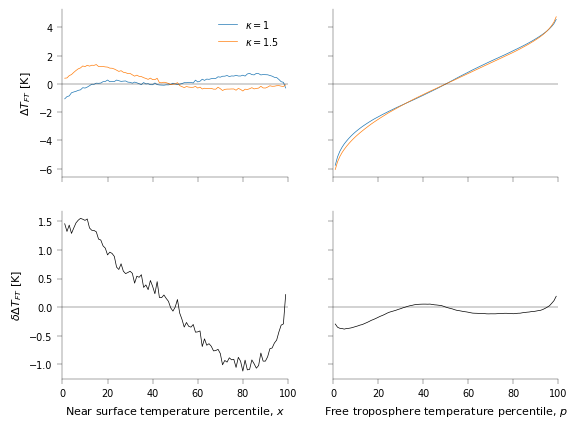

In [15]:
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey='row')
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, np.average(temp_quant3[i, ind_ft]-temp_av['median'][i, ind_ft, :, np.newaxis], weights=lat_weights, axis=0),
                  color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0, 1].plot(quant_plot, np.average(temp_ft_quant[i]-temp_ft_median[i, :, np.newaxis], weights=lat_weights, axis=0),
                  color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
ax[1, 0].plot(quant_plot, np.average(temp_quant3[1, ind_ft]-temp_av['median'][1, ind_ft, :, np.newaxis] - 
                                     (temp_quant3[0, ind_ft]-temp_av['median'][0, ind_ft, :, np.newaxis]), weights=lat_weights, axis=0),
              color='k')
ax[1, 1].plot(quant_plot, np.average(temp_ft_quant[1]-temp_ft_median[1, :, np.newaxis] - 
                                     (temp_ft_quant[0]-temp_ft_median[0, :, np.newaxis]), weights=lat_weights, axis=0), color='k')
ax[0, 0].legend()
ax[0, 0].set_xlim(0, 100)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[1, 0].set_xlabel('Near surface temperature percentile, $x$')
ax[1, 1].set_xlabel('Free troposphere temperature percentile, $p$')
ax[0, 0].set_ylabel('$\Delta T_{FT}$ [K]')
ax[1, 0].set_ylabel('$\delta \Delta T_{FT}$ [K]')

### Free troposphere percentile, $p_x$, corresponding to $x$
Below I plot compute the free troposphere, $T_{FT}(x)$ averaged over all days with near-surface temperature percentile $x$.

I then, compute the free troposphere temperature percentile $p_x$ such that the $p_x^{th}$ percentile of $T_{FT}$ (I use square bracket notation $T_{FT}[p_x]$ for this) equals $T_{FT}(x)$. I.e. $p_x$ is defined such that $T_{FT}[p_x] = T_{FT}(x)$.

I plot $p_x$ vs $x$ below. Note, $x$ runs from 1 to 99 but $p_x$ does not have to fill all these values.

In [16]:
p_x = np.zeros((n_kappa, n_lat, n_quant))
for i in range(n_kappa):
    for j in range(n_lat):
        interp_func = scipy.interpolate.interp1d(temp_ft_quant[i, j], quant_plot, fill_value='extrapolate')
        for k in range(n_quant):
            p_x[i, j, k] = interp_func(temp_quant3[i, ind_ft, j, k])

In [17]:
## Sanity check that function produces same results
for i in range(n_kappa):
    for j in range(n_lat):
        if np.abs(get_p_x(temp_quant3[i, ind_ft, j], temp_ft_quant[i, j], quant_plot)[0] - p_x[i, j]).max() > 1e-9:
            print(f'p_x calc is wrong for i={i} and j={j}')

Text(0, 0.5, '$\\delta p_x$')

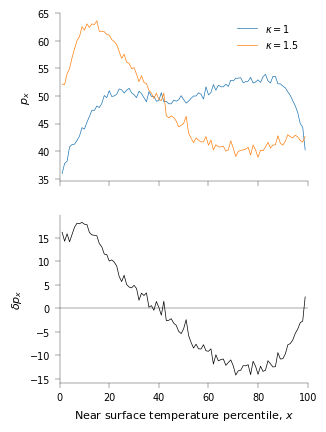

In [18]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(p_x[i], axis=0, weights=lat_weights), label=f'$\kappa={tau_lw[i]}$')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].plot(quant_plot, np.average(p_x[1] - p_x[0], axis=0, weights=lat_weights), color='k')
ax[0].legend()
ax[0].set_xlim(0, 100)
ax[1].set_xlabel('Near surface temperature percentile, $x$')
ax[0].set_ylabel('$p_x$')
ax[1].set_ylabel('$\delta p_x$')

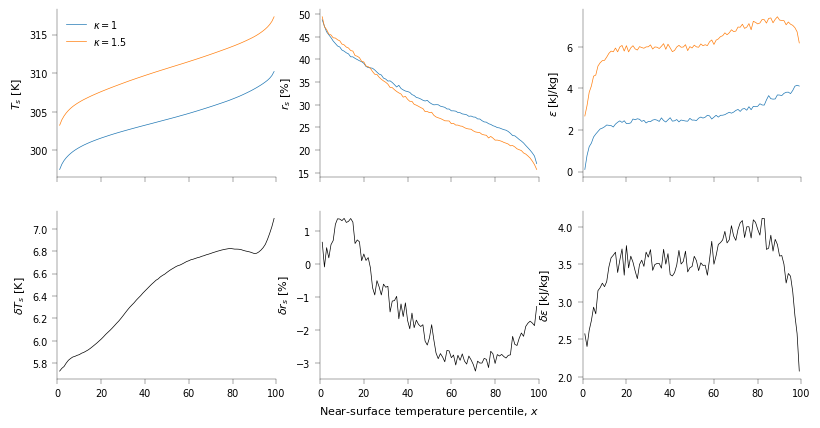

In [19]:
save_mse_surf_vars_fig = False
fig, ax = plt.subplots(2,3, figsize=(3*width['one_col'], 2*width['one_col']/ar), sharex=True)

for i, var in enumerate([temp_quant3[:, ind_surf], r_quant3*100, epsilon_quant3]):
    ax[0, i].plot(quant_plot, np.average(var[0], axis=0, weights=lat_weights), label=f'$\kappa={tau_lw[0]}$')
    ax[0, i].plot(quant_plot, np.average(var[1], axis=0, weights=lat_weights), label=f'$\kappa={tau_lw[1]}$')
    ax[1, i].plot(quant_plot, np.average(var[1]-var[0], axis=0, weights=lat_weights), color='k')
ax[0, 0].legend()
ax[0, 0].set_xlim(0, 100)
ax[1, 1].set_xlabel('Near-surface temperature percentile, $x$')

ax[0, 0].set_ylabel('$T_s$ [K]')
ax[0, 1].set_ylabel('$r_s$ [%]')
ax[0, 2].set_ylabel('$\epsilon$ [kJ/kg]')
ax[1, 0].set_ylabel('$\delta T_s$ [K]')
ax[1, 1].set_ylabel('$\delta r_s$ [%]')
ax[1, 2].set_ylabel('$\delta \epsilon$ [kJ/kg]')

if save_fig or save_mse_surf_vars_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_surf_vars_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [20]:
temp_ft_pxcold = np.zeros((n_kappa, n_lat, n_quant))
eta_pxcold = np.zeros((n_kappa, n_lat, n_quant))
epsilon_no_z = np.zeros((n_kappa, n_lat, n_quant))
c_p + lnp_const + L_v * clausius_clapeyron_factor(temp_ft_quant, pressure_ft_actual) * sphum_sat(temp_ft_quant, pressure_ft_actual)
p_x_ind = np.round(p_x).astype(int)-1      # use kappa=1 (colder) for p_x for both simulations in this
for i in range(n_kappa):
    for j in range(n_lat):
        # eta_mean[j] = np.polyfit(quant_plot[20:80], temp_ft_quant[0, j, 20:80], 1)[0]
        for q in range(n_quant):
            temp_ft_pxcold[i, j, q] = temp_ft_quant[i, j, p_x_ind[0, j, q]]
            eta_pxcold[i, j, q] = np.gradient(temp_ft_quant[i, j], quant_plot)[p_x_ind[0, j, q]]
            epsilon_no_z[i, j, q] = moist_static_energy(temp_quant3[i, ind_surf, j, q], sphum_quant3[i, j, q], 0, c_p_const=c_p-lnp_const) - \
                                        moist_static_energy(temp_ft_quant[i, j, p_x_ind[i, j, q]], sphum_sat(temp_ft_quant[i, j, p_x_ind[i, j, q]],
                                                                                                             pressure_ft_actual), 0, c_p_const=c_p+lnp_const)
alpha_ft_av = clausius_clapeyron_factor(temp_av[av_use][:, ind_ft], pressure_ft_actual)
q_sat_ft_av = sphum_sat(temp_av[av_use][:, ind_ft], pressure_ft_actual)
beta_ft1_av = c_p + lnp_const + L_v * alpha_ft_av * q_sat_ft_av

r_s_av_change = r_av[av_use][1] - r_av[av_use][0]
r_s_x_change = r_quant3[1] - r_quant3[0]

## Relating $\delta T_{FT}(x)$ to $\delta T_{FT}[p_x]$
We would first like to relate the change in free tropospheric temperature conditioned on the $x$ percenitle of near-surface temperature, $\delta T_{FT}(x)$, to how the actual FT distribution changes if the correspondence between the two did not change with warming, $\delta T_{FT}[p_x]$.

We have:

$\begin{align}
\delta T_{FT}(x) &= T_{FT}^{hot}[p_x + \delta p_x] - T_{FT}^{cold}[p_x]\\
&= \delta T_{FT}[p_x] + \int_{p_x}^{p_x + \delta p_x} \frac{\partial T^{hot}_{FT}}{\partial p} dp\\
&= \delta T_{FT}[p_x] + \int_{p_x}^{p_x + \delta p_x} \eta[p] + \delta \eta[p] dp\\
&\approx \delta T_{FT}[p_x] + \eta[p_x]\delta p_x + \delta \eta[p_x]\delta p_x\\
&\approx \delta T_{FT}[p_x] + \eta[p_x]\delta p_x
\end{align}$

where $\delta T_{FT}[p_x] = T^{hot}_{FT}[p_x] - T^{cold}_{FT}[p_x]$ and $\eta = \frac{\partial T_{FT}}{\partial p}$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


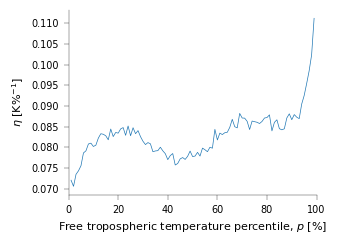

In [22]:
# eta_aqua = eta_pxcold[1]
# eta_land = eta_pxcold[1]

save_eta_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(eta_pxcold[0], axis=0, weights=lat_weights))
# ax.plot(quant_plot, np.average(eta_aqua, axis=0, weights=lat_weights), color=default_colors[0], label='Aquaplanet')
# ax.plot(quant_plot, np.average(eta_land, axis=0, weights=lat_weights), color=default_colors[3], label='Land')
ax.legend()
ax.set_xlabel('Free tropospheric temperature percentile, $p$ [%]')
ax.set_ylabel('$\eta$ [K%$^{-1}$]')
ax.set_xlim(0, 100)

if save_fig or save_eta_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/eta_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

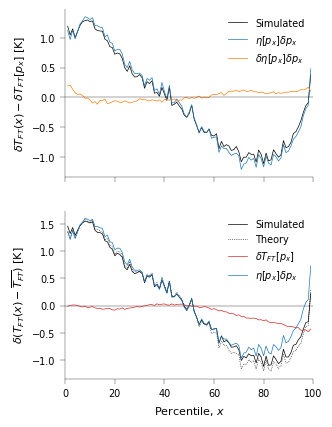

In [26]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft] - (temp_ft_pxcold[1] - temp_ft_pxcold[0]), axis=0, weights=lat_weights), 
        color='k', label='Simulated')
# ax.plot(quant_plot, np.average(temp_ft_quant[1] - temp_ft_quant[0], axis=0, weights=lat_weights), label='$\delta T_{FT}[x]$')
ax[0].plot(quant_plot, np.average(eta_pxcold[0] * (p_x[1]-p_x[0]), axis=0, weights=lat_weights), label='$\eta[p_x]\delta p_x$')
ax[0].plot(quant_plot, np.average((eta_pxcold[1] - eta_pxcold[0]) * (p_x[1]-p_x[0]), axis=0, weights=lat_weights), label='$\delta \eta[p_x] \delta p_x$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].legend()
ax[1].set_xlabel('Percentile, $x$')
ax[0].set_ylabel('$\delta T_{FT}(x) - \delta T_{FT}[p_x]$ [K]')
ax[1].set_ylabel('$\delta (T_{FT}(x) - \overline{T_{FT}})$ [K]')

ax[1].plot(quant_plot, np.average(temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft] - 
                                  (temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft])[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
           color='k', label='Simulated')
var = temp_ft_pxcold[1] - temp_ft_pxcold[0] + eta_pxcold[0] * (p_x[1]-p_x[0])
ax[1].plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Theory', linestyle=':')
var = temp_ft_pxcold[1] - temp_ft_pxcold[0]
ax[1].plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
           color=default_colors[3], label='$\delta T_{FT}[p_x]$')
var = eta_pxcold[0] * (p_x[1]-p_x[0]) - (eta_pxcold[0] * (p_x[1]-p_x[0]))[:, quant_median_ind, np.newaxis]
ax[1].plot(quant_plot, np.average(var, axis=0, weights=lat_weights), color=default_colors[0], label='$\eta[p_x]\delta p_x$')
var = (eta_pxcold[1] - eta_pxcold[0]) * (p_x[1]-p_x[0])
ax[1].legend()

### Isolating $x$ dependence of $\eta[p_x]$

Below I decompose this further to separate the $x$ dependence of $\delta p_x$ from $\eta[p_x]$.

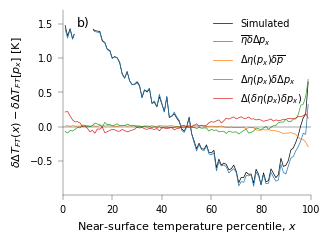

In [27]:
p_x_anom = p_x - p_x[:, :, quant_median_ind, np.newaxis]
temp_ft_pxcold_anom = temp_ft_pxcold - temp_ft_pxcold[:, :, quant_median_ind, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)

var = temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft] - (temp_ft_pxcold[1] - temp_ft_pxcold[0])
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
        color='k', label='Simulated')

var = eta_pxcold[0, :, quant_median_ind, np.newaxis] * (p_x_anom[1]-p_x_anom[0])
var_sum = np.zeros_like(var) + var
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\overline{\eta}\delta \Delta p_x$')

var = (eta_pxcold[0] - eta_pxcold[0, :, quant_median_ind, np.newaxis]) * (p_x[1]-p_x[0])[:, quant_median_ind, np.newaxis]
var_sum += var
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\Delta \eta(p_x)\delta \overline{p}$')

var = (eta_pxcold[0] - eta_pxcold[0, :, quant_median_ind, np.newaxis]) * (p_x_anom[1]-p_x_anom[0])
var_sum += var
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\Delta \eta(p_x)\delta \Delta p_x$')

var = (eta_pxcold[1] - eta_pxcold[0]) * (p_x[1]-p_x[0])
var_sum += var
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\Delta (\delta \eta(p_x)\delta p_x)$')

# ax.plot(quant_plot, np.average(var_sum - var_sum[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory')

ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.legend()
ax.set_xlabel('Near-surface temperature percentile, $x$')
ax.set_ylabel('$\delta \Delta T_{FT}(x) - \delta \Delta T_{FT}[p_x]$ [K]')

if is_land_data:
    label_subplots(fig, [ax], ['b)'])
else:
    ax.legend()
    label_subplots(fig, [ax])

In [29]:
## Sanity check that function produces same results
check_func = False
if check_func:
    simple = False
    a = np.zeros((n_lat, n_quant))
    for j in range(n_lat):
        var = decompose_temp_ft_anom_change(temp_av[av_use][:, ind_ft, j], temp_quant3[:, ind_ft, j], temp_ft_quant[:, j], quant_plot, simple=simple)
        a[j] = var[1]
    var = temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft]
    plt.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Simulated')
    if simple:
        var = temp_ft_pxcold[1] - temp_ft_pxcold[0] + eta_pxcold[0, :, quant_median_ind, np.newaxis] * (p_x_anom[1]-p_x_anom[0])
    else:
        var = temp_ft_pxcold[1] - temp_ft_pxcold[0] + var_sum
    plt.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color=default_colors[0], label='computed here')
    plt.plot(quant_plot, np.average(a, axis=0, weights=lat_weights), color='r', alpha=0.3, lw=4, label='function')
    plt.plot(quant_plot, np.average(a - (var - var[:, quant_median_ind, np.newaxis]), axis=0, weights=lat_weights), color='green', label='difference')
    plt.legend()
    plt.ylabel('$\delta \Delta T_{FT}(x)$')

### Equation for $\delta p_x$
The above equation works if we have a theory for $\delta p_x$. We get this by considering $\delta \epsilon(x)$:

$\begin{align}
\delta \epsilon(x) &\approx \epsilon(T_{FT}^{hot}[p_x + \delta p_x], T_s(x) + \delta T_s(x), r_s(x) + \delta r_s(x)) - 
\epsilon(T_{FT}^{cold}[p_x], T_s(x), r_s(x))\\
&= \epsilon(T^{hot}_{FT}[p_x] + \int_{p_x}^{p_x + \delta p_x} \frac{\partial T^{hot}_{FT}}{\partial p} dp, T_s(x) + 
\delta T_s(x), r_s(x) + \delta r_s(x)) - \epsilon(T^{cold}_{FT}[p_x], T_s(x), r_s(x))\\
&\approx \epsilon(T_{FT}[p_x] + \delta T_{FT}[p_x], T_s(x) + \delta T_s(x), r_s(x) + \delta r_s(x)) - 
\epsilon(T_{FT}[p_x], T_s(x), r_s(x)) \\
&+\frac{\partial \epsilon}{\partial T_{FT}}\bigg|_{T^{hot}_{FT}[p_x]} \int_{p_x}^{p_x + \delta p_x} \frac{\partial T^{hot}_{FT}}{\partial p} dp\\
&\approx \delta \epsilon(T_{FT}[x], T_s(x), r_s(x)) - \beta_{FT1}[p_x]\eta[p_x]\delta p_x
\end{align}$

where $\beta_{FT1}[p_x] = \frac{d h^{\dagger}}{d T_{FT}}\bigg |_{T^{cold}_{FT}[p_x]} \approx - \frac{\partial \epsilon}{\partial T_{FT}}\bigg|_{T^{cold}_{FT}[p_x]}$ and we assume $\delta \beta_{FT1}[p_x] \approx 0$, and use our previous algebra to get to the last line. 

The first line is an approximation as we replace $z$ with $T$. The effect of this is shown by the difference between the two green lines below.

Below we see that we can approximate $\delta p_x$ well by setting $\beta_{FT1}[p_x] \approx \overline{\beta_{FT1}} = \beta_{FT1}(x=50)$. It seems this approximation to get rid of the $x$ dependence of $\beta_{FT1}$ is fine, but the $\delta \beta_{FT1} \approx 0$ approximation is more problematic, as shown by the equivalence (difference) between the orange and green (blue and orange) lines below.

Text(0, 0.5, '$\\delta p_x$')

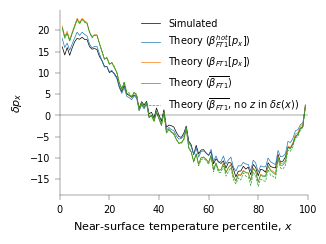

In [61]:
epsilon_pxcold = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, 0, c_p_const=c_p-lnp_const) - \
                                        moist_static_energy(temp_ft_pxcold, sphum_sat(temp_ft_pxcold, pressure_ft_actual), 0, c_p_const=c_p+lnp_const)
beta_ft1_pxcold = c_p + lnp_const + L_v * clausius_clapeyron_factor(temp_ft_pxcold, pressure_ft_actual) * sphum_sat(temp_ft_pxcold, pressure_ft_actual)

p_x_change_theory1 = ((epsilon_pxcold[1] - epsilon_pxcold[0]) - (epsilon_quant3[1] - epsilon_quant3[0]))*1000 / (beta_ft1_pxcold[1] * eta_pxcold[0])
p_x_change_theory2 = ((epsilon_pxcold[1] - epsilon_pxcold[0]) - (epsilon_quant3[1] - epsilon_quant3[0]))*1000 / (beta_ft1_pxcold[0] * eta_pxcold[0])
p_x_change_theory3 = ((epsilon_pxcold[1] - epsilon_pxcold[0]) - (epsilon_quant3[1] - epsilon_quant3[0]))*1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0])
p_x_change_theory3_no_z = ((epsilon_pxcold[1] - epsilon_pxcold[0]) - (epsilon_no_z[1] - epsilon_no_z[0])
                           )*1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0])
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(p_x[1] - p_x[0], axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(p_x_change_theory1, axis=0, weights=lat_weights), label='Theory ($\\beta^{hot}_{FT1}[p_x]$)')
ax.plot(quant_plot, np.average(p_x_change_theory2, axis=0, weights=lat_weights), label='Theory ($\\beta_{FT1}[p_x]$)')
ax.plot(quant_plot, np.average(p_x_change_theory3, axis=0, weights=lat_weights), 
        label='Theory ($\overline{\\beta_{FT1}}$)')
ax.plot(quant_plot, np.average(p_x_change_theory3_no_z, axis=0, weights=lat_weights), 
        label='Theory ($\overline{\\beta_{FT1}}$, no $z$ in $\delta \epsilon(x)$)', color=default_colors[2], linestyle='--')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.legend()
ax.set_xlabel('Near-surface temperature percentile, $x$')
ax.set_ylabel('$\delta p_x$' )

### Relating $\delta p_x$ to $\delta r_s$

Intuitively it makes sense if $\delta p_x$ is related to $\delta r_s$, as if relative humidity remained constant, one would expect increase in surface temperature to be replicated at FT level so $p_x$ would not change. We can quantify this by expanding out the $\delta \epsilon(T_{FT}[p_x], T_s(x), r_s(x))$ term in the above equation:

$\begin{align}
\delta \epsilon(T_{FT}[p_x], T_s(x), r_s(x)) &= \epsilon(T_{FT}[p_x] + \delta T_{FT}[p_x], T_s(x) + \delta T_s(x), r_s(x) + \delta r_s(x)) - 
\epsilon(T_{FT}[x], T_s(x), r_s(x))\\
&\approx \epsilon(T_{FT}[p_x] + \delta T_{FT}[p_x], T_s(x) + \delta T_s(x), r_s(x)) - 
\epsilon(T_{FT}[p_x], T_s(x), r_s(x)) + \frac{\partial \epsilon}{\partial r_s}\bigg|_{T^{hot}_s(x)} \delta r_s(x) \\
&= \delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) + L_v q_s^*(T_s(x) + \delta T_s(x))\delta r_s(x)\\
&\approx \delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) + L_v q_s^*(x)(1 + \alpha_s(x)\delta T_s(x))\delta r_s(x)
\end{align}$

Combining this with the previous equation, we get a new theory for $\delta p_x$:

$
\delta \epsilon(x) \approx \delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) + L_v q_s^*(x)(1 + \alpha_s(x)\delta T_s(x))\delta r_s(x) - \overline{\beta_{FT1}}\eta[p_x]\delta p_x
$

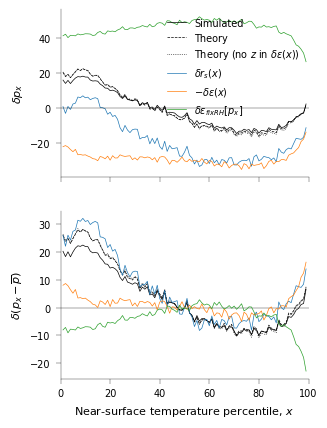

In [62]:
epsilon_pxcold_fixRH = np.zeros((n_kappa, n_lat, n_quant))
for j in range(n_kappa):
    for i in range(n_lat):
        for q in range(n_quant):
            epsilon_pxcold_fixRH[j, i, q] = moist_static_energy(temp_quant3[j, ind_surf, i, q],
                                                                   r_quant3[0, i, q] * sphum_sat(temp_quant3[j, ind_surf, i, q], p_surface), 
                                                                   0, c_p_const=c_p-lnp_const) - \
                                               moist_static_energy(temp_ft_pxcold[j, i, q], 
                                                                   sphum_sat(temp_ft_pxcold[j, i, q], pressure_ft_actual), 
                                                                   0, c_p_const=c_p+lnp_const)
epsilon_change_rh_cont = L_v * sphum_sat(temp_quant3[1, ind_surf], p_surface) * r_s_x_change / 1000
p_x_change_theory4 = ((epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) - (epsilon_quant3[1] - epsilon_quant3[0]) +  epsilon_change_rh_cont
                      ) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0])
p_x_change_theory4_no_z = ((epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) - (epsilon_no_z[1] - epsilon_no_z[0]) +  epsilon_change_rh_cont
                      ) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0])

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(p_x[1] - p_x[0], axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(p_x_change_theory4, axis=0, weights=lat_weights), color='k', label='Theory', linestyle='--')
ax[0].plot(quant_plot, np.average(p_x_change_theory4_no_z, axis=0, weights=lat_weights), color='k', label='Theory (no $z$ in $\delta \epsilon(x))$', linestyle=':')
ax[0].plot(quant_plot, np.average(epsilon_change_rh_cont * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0]), axis=0, weights=lat_weights), 
        label='$\delta r_s(x)$')
ax[0].plot(quant_plot, -np.average((epsilon_quant3[1] - epsilon_quant3[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0]), axis=0, weights=lat_weights), 
        label='$-\delta \epsilon(x)$')
ax[0].plot(quant_plot, np.average((epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0]), axis=0, weights=lat_weights), 
        label='$\delta \epsilon_{fixRH}[p_x]$')
ax[0].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[1].set_xlabel('Near-surface temperature percentile, $x$')
ax[0].set_ylabel('$\delta p_x$' )
ax[1].set_ylabel('$\delta (p_x - \overline{p})$' )

ax[1].plot(quant_plot, np.average(p_x[1] - p_x[0] - (p_x[1] - p_x[0])[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quant_plot, np.average(p_x_change_theory4 - p_x_change_theory4[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
        color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(p_x_change_theory4_no_z - p_x_change_theory4_no_z[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
        color='k', linestyle=':')
for i, var in enumerate([epsilon_change_rh_cont * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0]), 
                         -(epsilon_quant3[1] - epsilon_quant3[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0]),
                         (epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold[0])]):
    ax[1].plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights))

### Isolating $x$ dependence of $\eta[p_x]$
By writing $\eta[p_x] = \overline{\eta} + \Delta\eta[p_x]$, we can split each term into four terms e.g.

$\frac{\delta \epsilon(x)}{\eta[p_x]} = \frac{\delta \overline{\epsilon}}{\overline{\eta}} + \frac{\Delta \delta \epsilon(x)}{\overline{\eta}} - 
\frac{\Delta \eta[p_x]\delta \overline{\epsilon}}{\overline{\eta}\eta[p_x]} - \frac{\Delta \eta[p_x]\Delta \delta \epsilon(x)}{\overline{\eta}\eta[p_x]}$

The first term is the average. The second (third) term has $x$ dependence just in $\epsilon$ ($\eta$), this is shown by the solid (dot-dashed) line. The red line is the sum of the dot-dashed lines. The last term is the non-linear term, shown by the dashed line below. This is exact, and we don't use taylor expansion because that requires $\left|\frac{\Delta \eta[p_x]}{\overline{\eta}}\right|<<1$, which we don't fulfil for large and small $x$. The blue line in the bottom plot above is equal to the sum of all the blue lines below. The same goes for all the other coloured lines.

The linear (non-linear) terms are shown by solid (dashed) lines below. Clearly, the non-linear terms are significant.

3.730349362740526e-14


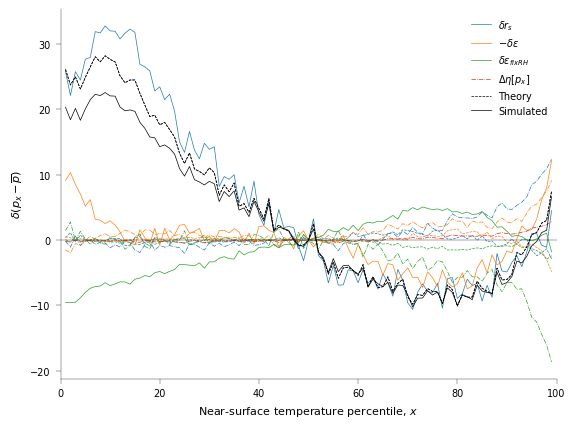

In [63]:
eta_pxcold_av = eta_pxcold[:, :, quant_median_ind]
eta_pxcold_anom = (eta_pxcold - eta_pxcold_av[:, :, np.newaxis]) / eta_pxcold
p_x_change_theory4_additive = np.zeros_like(p_x_change_theory4)
p_x_change_theory4_eta_anom_term = np.zeros_like(p_x_change_theory4)
labels_use = ['$\delta r_s$', '$-\delta \epsilon$', '$\delta \epsilon_{fixRH}$', '$\delta \epsilon_{fixRH}$']

save_p_x_anom_breakdown_fig = False
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
for i, var in enumerate([epsilon_change_rh_cont * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold_av[0, :, np.newaxis]), 
                         -(epsilon_quant3[1] - epsilon_quant3[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold_av[0, :, np.newaxis]),
                         (epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) * 1000 / (beta_ft1_av[0, :, np.newaxis] * eta_pxcold_av[0, :, np.newaxis])]):
    # ax[0].plot(quant_plot, np.average(var, axis=0, weights=lat_weights), color=default_colors[i], label=labels_use[i])
    # ax[0].plot(quant_plot, np.average(-(var - ) * eta_pxcold_anom[0], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--', 
    #            label='non-linear' if i==0 else None)
    ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color=default_colors[i], label=labels_use[i])
    ax.plot(quant_plot, -np.average((var - var[:, quant_median_ind, np.newaxis]) * eta_pxcold_anom[0], axis=0, weights=lat_weights), color=default_colors[i], 
            linestyle='--')
    ax.plot(quant_plot, -np.average(var[:, quant_median_ind, np.newaxis] * eta_pxcold_anom[0], axis=0, weights=lat_weights), color=default_colors[i], 
            linestyle='-.')
    p_x_change_theory4_additive += var - var[:, quant_median_ind, np.newaxis] - (var - var[:, quant_median_ind, np.newaxis]) * eta_pxcold_anom[0]
    # ax[1].plot(quant_plot, np.average(-var * eta_pxcold_anom[0] - (-var * eta_pxcold_anom[0])[:, quant_median_ind, np.newaxis], 
    #                                   axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
    p_x_change_theory4_eta_anom_term -= var[:, quant_median_ind, np.newaxis] * eta_pxcold_anom[0]
p_x_change_theory4_additive += p_x_change_theory4_eta_anom_term
# p_x_change_theory3_eta_anom_term = -eta_pxcold_anom[0] * p_x_change_theory3_const_eta[:, quant_median_ind, np.newaxis]
ax.plot(quant_plot, np.average(p_x_change_theory4_eta_anom_term, axis=0, weights=lat_weights), color=default_colors[3], label='$\Delta \eta[p_x]$', linestyle='-.')
ax.plot(quant_plot, np.average(p_x_change_theory4_additive, axis=0, weights=lat_weights), color='k', label='Theory', linestyle='--')
ax.plot(quant_plot, np.average(p_x_change_theory4 - p_x_change_theory4[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
        color='k', linestyle='--')
ax.plot(quant_plot, np.average(p_x[1] - p_x[0] - (p_x[1] - p_x[0])[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Simulated')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.legend()
ax.set_xlabel('Near-surface temperature percentile, $x$')
ax.set_ylabel('$\delta p_x$' )
ax.set_ylabel('$\delta (p_x - \overline{p})$')

if save_fig or save_p_x_anom_breakdown_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/p_x_anom_breakdown_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

# sanity check that additive form is correct
print(np.abs(p_x_change_theory4 - p_x_change_theory4[:, quant_median_ind, np.newaxis] - p_x_change_theory4_additive).max()) 

## What does this mean for $\frac{\delta T_s(x)}{\delta \overline{T_s}}$ theory?
Using this, we can replace the $\delta \Delta T_{FT}(x)$ and $\delta \Delta \epsilon(x)$ terms in the theory. Combining the $\delta T_{FT}(x)$ and $\delta \epsilon(x)$ approximations above, we get a final approximation for $\delta T_{FT}(x)$ which explicitly relates it to $\delta r_s(x)$:

$\begin{align}
\delta T_{FT}(x) &\approx \delta T_{FT}[p_x] + \frac{1}{\overline{\beta_{FT1}}}\left(\delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) - \delta \epsilon(x) + L_v q_s^*(x)(1 + \alpha_s(x)\delta T_s(x))\delta r_s(x)\right)\\
&= \delta T_{FT}[p_x] + \frac{1}{\overline{\beta_{FT1}}}\left(\delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) - \delta \epsilon(x) + L_v q_s^*(x)\delta r_s(x) + \beta_{s1}(x)\mu(x)\frac{\delta r_s(x)}{r_s(x)}\delta T_s(x)\right)
\end{align}$

where $\beta_{s1} = \frac{\partial h^{\dagger}}{\partial T_s} = c_p - R^{\dagger} + L_v \alpha_sq_s$ and  $\mu = \frac{L_v \alpha_s q_s}{\beta_{s1}}$.

We can use this to sub into the surface expansion of $\delta h^{\dagger}(x)$: 

$\begin{align}
\delta h^{\dagger}(x) &\approx \beta_{s1}(x)\left(1 + \mu(x)\frac{\delta r_s(x)}{r_s(x)}\right)\delta T_s(x) + L_v q_s^*(x)\delta r_s(x) - \delta \epsilon(x)\\
&\approx \beta_{s1}(x) \delta T_s(x) + \overline{\beta_{FT1}}(\delta T_{FT}(x) - \delta T_{FT}[p_x]) - \delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x))
\end{align}$

So, we get:

$\delta \Delta h^{\dagger}(x) \approx \beta_{s1}(x) \delta T_s(x) - \overline{\beta_{s1}} \delta \overline{T_s} + 
\overline{\beta_{FT1}}(\delta \Delta T_{FT}(x) - \delta \Delta T_{FT}[p_x]) - \delta \Delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x))$

where $\Delta T_{FT}[p_x] = T_{FT}[p_x] - T_{FT}[p_{x=50}]$ and $\Delta \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) = \epsilon_{fix RH}(T_{FT}[p_x], T_s(x)) - \epsilon_{fix RH}(T_{FT}[p_{x=50}], T_s(x=50))$.

This allows us to remove the $\delta \Delta r_s(x)$ term completely from our equation for $\frac{\delta T_s(x)}{\delta \overline{T_s}}$.

### Interpretation
The interpretation of this plot is that the orange line is quite close to 1, so the CAPE change can mainly be explained by the change in the surface and free tropospheric distributions; without accounting for change in percentile or relative humidity changes. The relative humidity term is thus responsible for the change in $p_x$, as is more explicity in the $\delta p_x$ equation above. So basically, by extracting a $\delta p_x$ term from $\delta T_{FT}(x)$, we extract the RH dependent part.

Basically, if the orange line is near 0, then $\delta p_x$ is due to RH changes.

Text(0, 0.5, '$\\delta \\Delta T_{FT}(x)$ [K]')

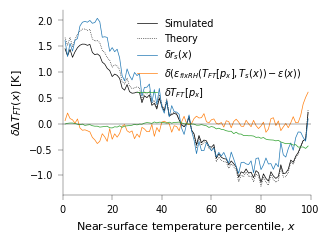

In [64]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))

var = (temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft])
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Simulated')

var = (temp_ft_pxcold[1] - temp_ft_pxcold[0]) + ((epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) - (epsilon_quant3[1] - epsilon_quant3[0])) / beta_ft1_av[0, :, np.newaxis] * 1000 + epsilon_change_rh_cont / beta_ft1_av[0, :, np.newaxis] * 1000
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory')

var = epsilon_change_rh_cont / beta_ft1_av[0, :, np.newaxis] * 1000
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\delta r_s(x)$')

var = ((epsilon_pxcold_fixRH[1] - epsilon_pxcold_fixRH[0]) - (epsilon_quant3[1] - epsilon_quant3[0])) / beta_ft1_av[0, :, np.newaxis] * 1000
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), 
        label='$\delta (\epsilon_{fixRH}(T_{FT}[p_x], T_s(x)) - \epsilon(x))$')

var = (temp_ft_pxcold[1] - temp_ft_pxcold[0])
ax.plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), label='$\delta T_{FT}[p_x]$')

ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.set_xlabel('Near-surface temperature percentile, $x$')
ax.set_ylabel('$\delta \Delta T_{FT}(x)$ [K]')

### Simpler relationship
More simply, we can write:
 
$\gamma_{FT}\frac{\delta \Delta T_{FT}(x)}{\delta \overline{T_s}} \approx \frac{\gamma_{FT}}{\delta \overline{T_s}}(\delta \Delta T_{FT}[p_x] + 
\overline{\eta}\delta \Delta p_x)$

Below, we see that $\overline{\eta}\gamma_{FT}\frac{\delta \Delta p_x}{\delta \overline{T_s}} \approx \gamma_{\delta \Delta r}\frac{\delta \Delta r_s(x)}{\delta \overline{T_s}}$

And when this is not the case, the residual is anti-correlated with the $\delta \Delta \epsilon$ term.

In [65]:
temp_s_av_change = temp_av[av_use][1, ind_surf] - temp_av[av_use][0, ind_surf]
sf_simulated = (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / temp_s_av_change[:, np.newaxis]
key_use_theory = 'linear'
sf_theory = {key_use_theory: np.zeros((n_lat, n_quant))}
keys_sf_breakdown = {var+'_mean_change': ['t0', 't0_r0', 'r0', 'e0'] for var in ['t', 'r', 'e']}
keys_sf_breakdown['anomaly_change'] = ['r', 't0_r', 'ft', 'e']
gamma_ft = np.zeros(n_lat)
sf_theory_breakdown = {key1: {key2: np.zeros((n_lat, n_quant)) for key2 in keys_sf_breakdown[key1]} for key1 in keys_sf_breakdown}
mu_factor_x = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for key in sf_theory:
        sf_theory[key][i], info_coef, _, info_cont, mu_factor_x[i] = get_scaling_factor_theory(temp_av[av_use][:, ind_surf, i], 
                                                                                               temp_quant3[:, ind_surf, i], 
                                                                          sphum_av[av_use][:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual,
                                                                          temp_av[av_use][:, ind_ft, i], temp_quant3[:, ind_ft, i], 
                                                                          z_av[av_use][:, ind_ft, i], z_quant3[:, ind_ft, i],
                                                                          non_linear='non_linear' in key, use_temp_adiabat=True, 
                                                                          strict_conv_eqb='sce' in key, 
                                                                          simple='simple' in key)
        # Only record breakdown for linear case as easier to interpret
        for key1 in keys_sf_breakdown:
            for key2 in keys_sf_breakdown[key1]:
                sf_theory_breakdown[key1][key2][i] = info_cont[key1][key2]
        gamma_ft[i] = info_coef['anomaly_change']['ft']
sf_theory_breakdown['anomaly_change']['px'] = (eta_pxcold_av[0] * gamma_ft / temp_s_av_change)[:, np.newaxis] * (p_x_anom[1] - p_x_anom[0]) / mu_factor_x
sf_theory_breakdown['anomaly_change']['ft_px'] = (gamma_ft / temp_s_av_change)[:, np.newaxis] * (temp_ft_pxcold_anom[1] - temp_ft_pxcold_anom[0]) / mu_factor_x
sf_theory['px'] = sf_theory[key_use_theory] - sf_theory_breakdown['anomaly_change']['ft'] + \
                  sf_theory_breakdown['anomaly_change']['ft_px'] + sf_theory_breakdown['anomaly_change']['px']

# mu_x = 1 - (c_p - lnp_const) / (c_p - lnp_const + L_v * clausius_clapeyron_factor(temp_quant3[0, ind_surf], p_surface) * sphum_quant3[0])
mu_factor_av = mu_factor_x[:, quant_median_ind]
# sf_theory_breakdown['anomaly_change']['r_t_s'] = mu_x * 

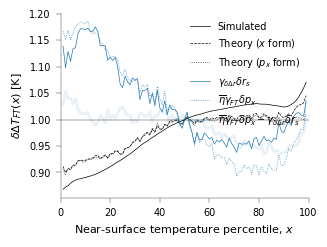

In [66]:
save_sf_with_px_fig = False

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average((temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf])/temp_s_av_change[:, np.newaxis], axis=0, weights=lat_weights),
        color='k', label='Simulated')
ax.plot(quant_plot, np.average(sf_theory[key_use_theory], axis=0, weights=lat_weights), color='k', linestyle='--', label='Theory ($x$ form)')
ax.plot(quant_plot, np.average(sf_theory['px'], axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory ($p_x$ form)')
ax.plot(quant_plot, 1-np.average(sf_theory_breakdown['anomaly_change']['r'], axis=0, weights=lat_weights), color=default_colors[0], 
        label='$\gamma_{\delta \Delta r}\delta r_s$')
ax.plot(quant_plot, 1+np.average(sf_theory_breakdown['anomaly_change']['px'], axis=0, weights=lat_weights), color=default_colors[0], linestyle=':', 
        label='$\overline{\eta}\gamma_{FT}\delta p_x$')
ax.plot(quant_plot, 1+np.average(sf_theory_breakdown['anomaly_change']['r'] + sf_theory_breakdown['anomaly_change']['px'], axis=0, weights=lat_weights),
        color=default_colors[0], lw=2, alpha=0.1, label='$\overline{\eta}\gamma_{FT}\delta p_x - \gamma_{\delta \Delta r}\delta r_s$')
# ax.plot(quant_plot, 1+np.average(sf_theory_breakdown['anomaly_change']['e'], axis=0, weights=lat_weights),
#         color=default_colors[1], label='$\gamma_{\delta \Delta \epsilon}\delta \Delta \epsilon$')
# ax.plot(quant_plot, np.average(mu_factor_av[:, np.newaxis]/mu_factor_x, axis=0, weights=lat_weights),
#         color=default_colors[1])
ax.legend()
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.set_xlabel('Near-surface temperature percentile, $x$')
ax.set_ylabel('$\delta \Delta T_{FT}(x)$ [K]')

if save_fig or save_sf_with_px_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_with_px_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)